In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


# definzioni funzioni varie

def timeserieFeatureExtractor(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['dayofyear'] = timeseries.index.dayofyear
    timeseries['dayofmonth'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
#     timeseries['daysinmonth'] = timeseries.index.daysinmonth
#     timeseries['month'] = timeseries.index.month
#     timeseries['year'] = timeseries.index.year
    timeseries['weekend'] = np.where(timeseries.index.dayofweek > 4, 1, 0)
    timeseries.fillna(0,inplace=True)
    return 

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

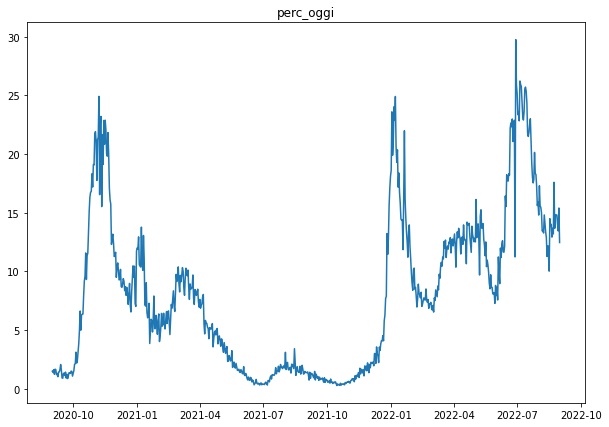

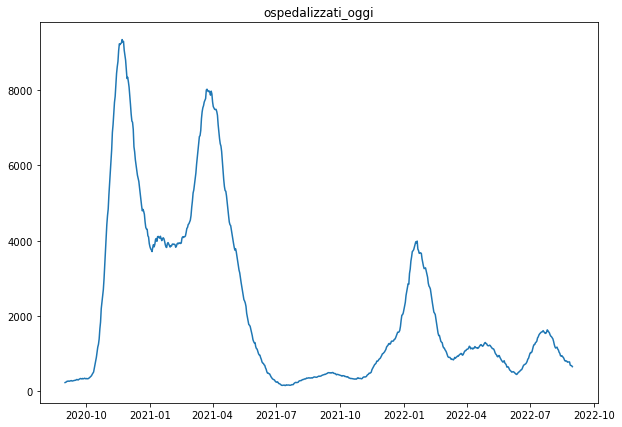

,perc_oggi,ospedalizzati_oggi,ospedalizzati_past1,ospedalizzati_past2,ospedalizzati_past3,ospedalizzati_past4,ospedalizzati_past5,ospedalizzati_past6,perc_past1,perc_past2,...,perc_past4,perc_past5,perc_past6,ospedalizzati_target,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,weekend
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,13.172857,810.0,803.0,820.0,866.0,904.0,918.0,947.0,12.930000,12.718571,...,12.318571,12.240000,12.175714,688.0,0,3,234,22,34,0
2022-08-23,14.254286,800.0,810.0,803.0,820.0,866.0,904.0,918.0,13.172857,12.930000,...,12.482857,12.318571,12.240000,680.0,1,3,235,23,34,0
2022-08-24,14.137143,775.0,800.0,810.0,803.0,820.0,866.0,904.0,14.254286,13.172857,...,12.718571,12.482857,12.318571,655.0,2,3,236,24,34,0
2022-08-25,14.265714,780.0,775.0,800.0,810.0,803.0,820.0,866.0,14.137143,14.254286,...,12.930000,12.718571,12.482857,0.0,3,3,237,25,34,0
2022-08-26,14.380000,780.0,780.0,775.0,800.0,810.0,803.0,820.0,14.265714,14.137143,...,13.172857,12.930000,12.718571,0.0,4,3,238,26,34,0
2022-08-27,14.650000,780.0,780.0,780.0,775.0,800.0,810.0,803.0,14.380000,14.265714,...,14.254286,13.172857,12.930000,0.0,5,3,239,27,34,1
2022-08-28,14.705714,694.0,780.0,780.0,780.0,775.0,800.0,810.0,14.650000,14.380000,...,14.137143,14.254286,13.172857,0.0,6,3,240,28,34,1
2022-08-29,14.742857,688.0,694.0,780.0,780.0,780.0,775.0,800.0,14.705714,14.650000,...,14.265714,14.137143,14.254286,0.0,0,3,241,29,35,0
2022-08-30,14.430000,680.0,688.0,694.0,780.0,780.0,780.0,775.0,14.742857,14.705714,...,14.380000,14.265714,14.137143,0.0,1,3,242,30,35,0


In [14]:
# dataframe from lombacovid.it
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)

data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

for i in data:
    plt.figure(figsize=(10,7))
    plt.plot(data[i])
    plt.title(i)
    plt.show()
    
# 1) feature engineering 
# perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

# ospedalizzati and perc_oggi lag features shifted by 10 days: t, t+1, ... t+n
past_days = 7           # <---
for i in range(1, past_days):
    data[f'ospedalizzati_past{i}'] = data['ospedalizzati_oggi'].shift(i).fillna(0)
for i in range(1, past_days):
    data[f'perc_past{i}'] = data['perc_oggi'].shift(i).fillna(0)

# of the target: ospedalizzati_oggi lagged by 7 days in the future: t-7
future_target = 7       # <---
data['ospedalizzati_target'] = data['ospedalizzati_oggi'].shift(-future_target).fillna(0)
data = data.fillna(0)

# 2) feature extraction
timeserieFeatureExtractor(data)

data.tail(10)

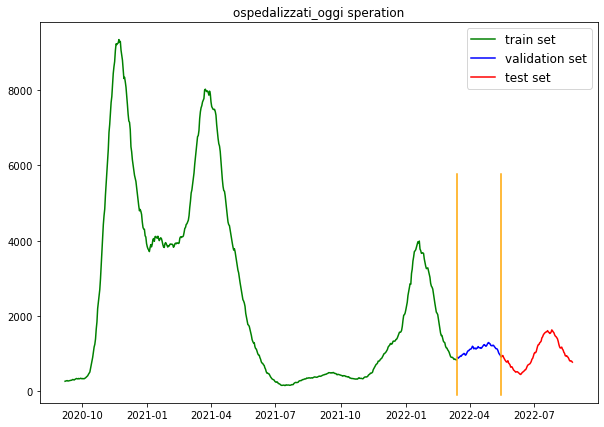

In [15]:
# train, test and validation length
len_train_train_test = int(len(data.index)-len(data.index)*15/100)
separation_index_train_test = list(data.index)[len_train_train_test]

len_train_val = int(len_train_train_test-len_train_train_test*10/100)
separation_index_train_val = list(data.index)[len_train_val]

separation_index_prediction = data.index[:-7][-1]

# feature splitting and plot
X = data.drop(columns='ospedalizzati_target')
X_train = X[X.index < separation_index_train_val]
X_val = X[(X.index > separation_index_train_val) & (X.index <= separation_index_train_test)]
X_test = X[(X.index > separation_index_train_test) & (X.index <= separation_index_prediction)]

plt.figure(figsize=(10,7))
plt.plot(X_train['ospedalizzati_oggi'],color='green',label='train set')
plt.plot(X_val['ospedalizzati_oggi'],color='blue',label='validation set')
plt.plot(X_test['ospedalizzati_oggi'],color='red',label='test set')
plt.axvline(x=separation_index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.axvline(x=separation_index_train_val, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi speration')
plt.legend(prop={'size': 12})
plt.show()

# target splitting
y = data['ospedalizzati_target']
y_train = y[y.index < separation_index_train_val]
y_val = y[(y.index > separation_index_train_val) & (data.index <= separation_index_train_test)]
y_test = y[(y.index > separation_index_train_test) & (y.index <= separation_index_prediction)]

[0]	validation_0-rmse:3325.89362	validation_1-rmse:1027.96643
[1]	validation_0-rmse:3008.45981	validation_1-rmse:945.91936
[2]	validation_0-rmse:2722.38058	validation_1-rmse:875.23890
[3]	validation_0-rmse:2463.67428	validation_1-rmse:733.42603
[4]	validation_0-rmse:2229.77887	validation_1-rmse:674.93184
[5]	validation_0-rmse:2018.69647	validation_1-rmse:623.43116
[6]	validation_0-rmse:1826.64307	validation_1-rmse:465.81235
[7]	validation_0-rmse:1654.78247	validation_1-rmse:325.95518
[8]	validation_0-rmse:1498.59005	validation_1-rmse:228.05713
[9]	validation_0-rmse:1358.31332	validation_1-rmse:137.90078
[10]	validation_0-rmse:1231.62757	validation_1-rmse:155.63424
[11]	validation_0-rmse:1116.55644	validation_1-rmse:181.30558
[12]	validation_0-rmse:1012.64217	validation_1-rmse:240.98068
[13]	validation_0-rmse:918.91392	validation_1-rmse:300.40357
[14]	validation_0-rmse:833.14677	validation_1-rmse:315.17826
[15]	validation_0-rmse:755.63056	validation_1-rmse:328.38707
[16]	validation_0-rm

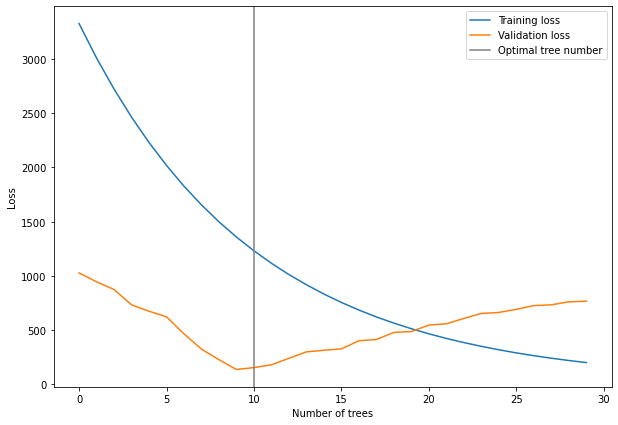

best trees numb: 10


In [16]:
# -> xgboost regressor
# early stopping rounds for xgboost
model = XGBRegressor(n_estimators=250, 
                         max_depth=6, 
                         learning_rate=0.1)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          early_stopping_rounds=20,
          verbose=True) 

# plot n° trees (x) vs loss function: rmse (y)
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()


best_numb_trees = model.best_ntree_limit
print(f'best trees numb: {best_numb_trees}')

Error on validation data
Mean Squared Error: 72807.4021
Root Mean Sqarred Error: 269.8285
Mean Absolute Error: 246.0946
Mean Absolute Percentage Error: 21.4552


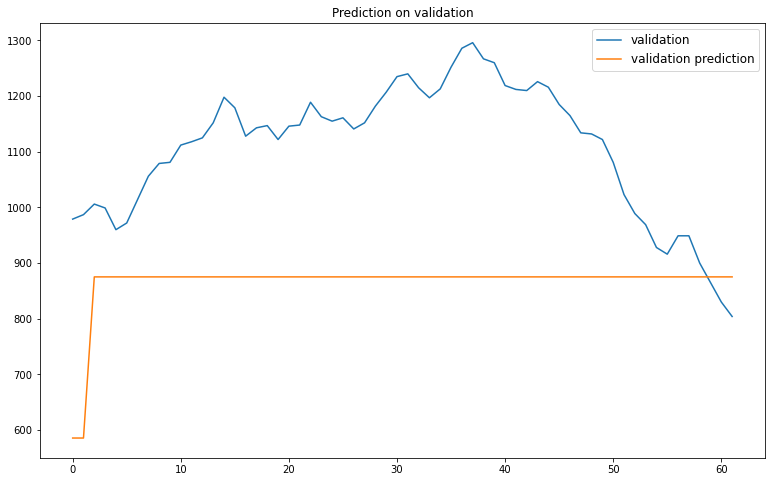

Error on test data
Mean Squared Error: 93882.6054
Root Mean Sqarred Error: 306.4027
Mean Absolute Error: 258.7262
Mean Absolute Percentage Error: 28.0175


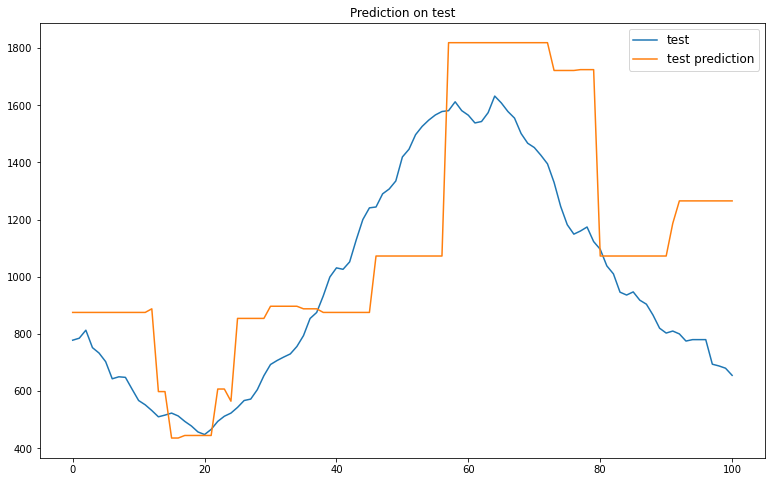

In [10]:
# -> fitting the model
model = XGBRegressor(
#                      booster = 'gbtree',
#                      eval_metric = 'rmse',
#                      objective = 'reg:squarederror',
                     eta = 0.1,
                     min_child_weight = 1,
                     max_depth = 6,
                     max_delta_step = 0,
                     subsample = 1,
                     colsample_bytree = 0.5,
                     colsample_bylevel = 1,
                     gamma = 1,
                     reg_lambda = 0.4,
                     reg_alpha = 0,
                     n_estimators = 6,
                     seed = 42)

model.fit(X_train, y_train)



# prediction of validation set
y_pred_val = model.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data')
calcError(y_val,y_pred_val)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,label='validation')
plt.plot(y_pred_val,label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation')
plt.show()



# prediction of test set
y_pred_test = model.predict(X_test)

# error on test on the first prediction 
print('Error on test data')
calcError(y_test,y_pred_test)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,label='test')
plt.plot(y_pred_test,label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test')
plt.show()


Error on validation data
Mean Squared Error: 94501.8992
Root Mean Sqarred Error: 307.4116
Mean Absolute Error: 266.0939
Mean Absolute Percentage Error: 23.9322


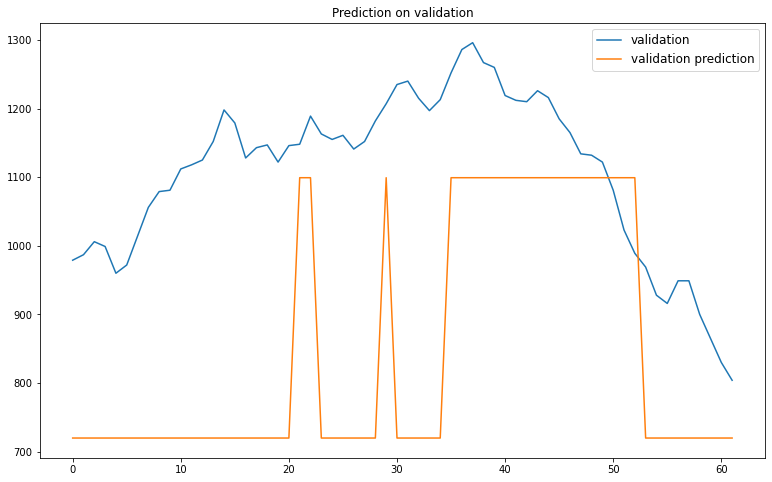

Error on test data
Mean Squared Error: 63293.5918
Root Mean Sqarred Error: 251.5822
Mean Absolute Error: 205.7922
Mean Absolute Percentage Error: 22.3649


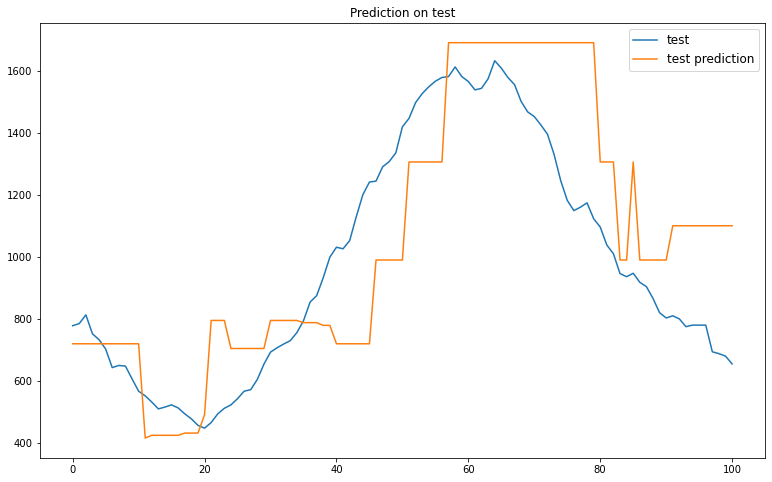

In [11]:
# -> tuning xgb parameters
# GridSeadchCV 
parameters = {'max_depth':[4,5,6,7],
              'eta':[0.09,0.1,0.11],
              'reg_lambda' : [0.35,0.4,0.45],
              'colsample_bytree' : [0.5,0.55,0.6,0.8]}

clf = GridSearchCV(model, 
                   parameters,
                   scoring = 'neg_mean_squared_error',verbose = False)

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose = False)

best_estimator = clf.best_estimator_



# prediction of validation after tuning
tune_y_val_pred = best_estimator.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data after tuning hyperparams')
calcError(y_val,tune_y_val_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,label='validation')
plt.plot(tune_y_val_pred,label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation after tuning hyperparams')
plt.show()



# prediction of test after tuning
tune_y_test_pred = best_estimator.predict(X_test)

# error on test on the first prediction 
print('Error on test data after tuning hyperparams')
calcError(y_test,tune_y_test_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,label='test')
plt.plot(tune_y_test_pred,label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test after tuning hyperparams')
plt.show()

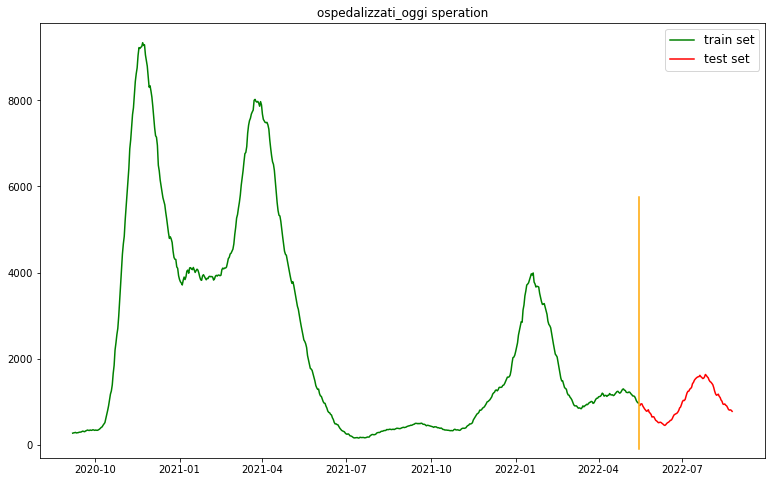

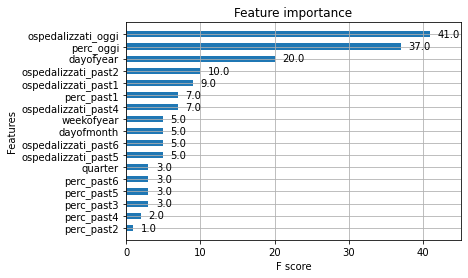

Error on test data after training the model on all training set
Mean Squared Error: 98123.5747
Root Mean Sqarred Error: 313.2468
Mean Absolute Error: 222.1903
Mean Absolute Percentage Error: 20.7691


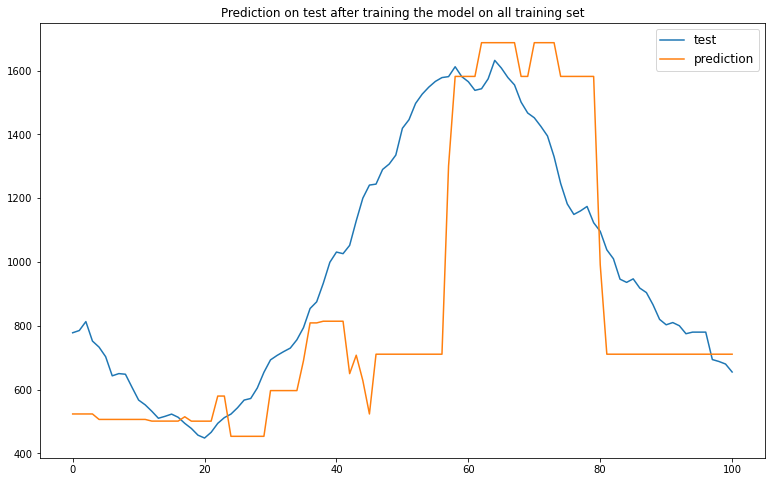

In [18]:
# -> fitting model on entire dataframe
X_train_total = X[X.index < separation_index_train_test]
X_test_total = X[(X.index > separation_index_train_test) & (X.index <= separation_index_prediction)]

y_train_total = y[y.index < separation_index_train_test]
y_test_total = y[(y.index > separation_index_train_test) & (y.index <= separation_index_prediction)]

plt.figure(figsize=(13,8))
plt.plot(X_train_total['ospedalizzati_oggi'],color='green',label='train set')
plt.plot(X_test_total['ospedalizzati_oggi'],color='red',label='test set')
plt.axvline(x=separation_index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi speration')
plt.legend(prop={'size': 12})
plt.show()

# fitting of xgb model after tuning
best_estimator.fit(X_train_total, y_train_total)

# prediction
y_pred_total = best_estimator.predict(X_test_total)

# feature importance of xgboost
plot_importance(best_estimator,height=0.5)
plt.show()

# error on the first prediction 
print('Error on test data after training the model on all training set')
calcError(y_test_total,y_pred_total)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test_total.values,label='test')
plt.plot(y_pred_total,label='prediction')
plt.title('Prediction on test after training the model on all training set')
plt.legend(prop={'size': 12})
plt.show()